## EXERCICE 12 : PLS parcimonieuse (sparse-PLS)

Nous allons maintenant creuser l'algorithme de la PLS vu précédement avec des donnees qui contiennent des relations plus complexes. Nous allons aussi essayer de detecter automatiquement les variables les plus pertinentes a l'aide d'une strategie L1 de parcimonie.


In [7]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale

#Generation de donnees
n = 1000
p = 10
X = np.random.normal(size=n * p).reshape((n, p))
X[:, 2]=0.5*X[:, 1]+0.1*np.random.normal(size=n)
X[:, 3]=0.4*X[:, 1]+0.1*np.random.normal(size=n)
y = 1.5 * X[:, 0] + 1 * X[:, 1]  + np.random.normal(size=n)





In [8]:

def PLS1(X,y,l):
    """
    PLS1 strategy - NIPALS algorithm

    Returns:
        - B: regression coefficients wrt the original predictors
        - W: orthonormal weights
        - P: matrix of X-loading
        - q: vector of y-loading
    """
    [n,p]=X.shape

    list_w_k=[]
    list_p_k=[]
    list_q_k=[]

    X_k=X.copy()
    v_k=np.dot(X_k.transpose(),y)
    w_k=v_k/np.linalg.norm(v_k)   #covariance of each variable with y

    for k in range(l):
        #compute the projections and loadings
        tau_k=np.dot(X_k,w_k)   #weighted sum of the variables with weights that emphasize the variables of X that are the most correlated with y
        t_k=tau_k/np.linalg.norm(tau_k)
        p_k=np.dot(X_k.transpose(),t_k)   #projector: weighted sum of the observations with weights that emphasize the observations whose values participate most to the covariance with y in average
        q_k=np.dot(t_k.transpose(),y) #captured variability in y

        #save the elements for the matrices
        list_w_k.append(w_k)
        list_p_k.append(p_k)
        list_q_k.append(q_k)

        #prepare the next iteration
        if k<l-1:
            X_k=X_k-np.dot(t_k.reshape(-1,1),p_k.reshape(1,-1))  #enleve l'information capturee par la projection de X_k sur t_k
            v_k=np.dot(X_k.transpose(),y)    #covariance de chaque variable (apres avoir enleve la projection des donnees sur les precedents t_k) avec y
            w_k=v_k/np.linalg.norm(v_k)

    #create the martices
    W=np.zeros([p,l])
    P=np.zeros([p,l])
    q=np.zeros(l)
    for i in range(l):
        W[:,i]=list_w_k[i]
        P[:,i]=list_p_k[i]
        q[i]=list_q_k[i]

    tmp=np.linalg.inv(np.dot(P.transpose(),W))
    B=np.dot(np.dot(W,tmp),q)

    return [B,W,P,q]



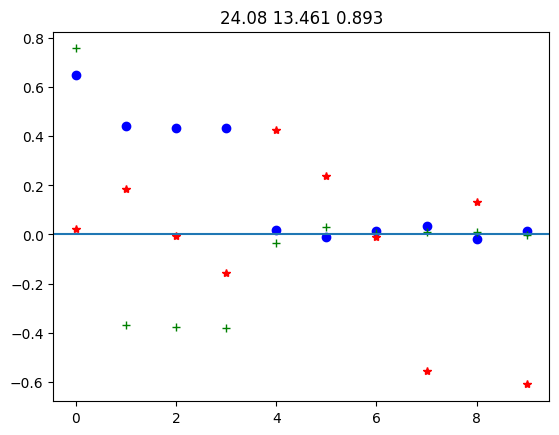

In [15]:
from sklearn.preprocessing import scale

#Data normalization
X=scale(X)
y=scale(y)

[B,W,P,q]=PLS1(X,y,3)

plt.plot(W[:,0],'bo')
plt.plot(W[:,1],'g+')
plt.plot(W[:,2],'r*')
plt.axline((0.,0.),(9.,0.))
plt.title(str(np.round(q[0],3))+' '+str(np.round(q[1],3))+' '+str(np.round(q[2],3)))
plt.show()





#### <span style="color:blue">QUESTION 1</span> 
    
Bien comprendre le detail de l'algorithme NIPALS qui est dans la fonction PLS1

Que representent les courbes du plot et les valeurs de q ?

#### <span style="color:blue">REPONSE 1 </span> 

    



Les W sont les projecteurs et les q la covariance avec y capturee par les projecteurs

On remarquera qu'un melange de toutes les variables pertinentes est capture par le 1er projecteur alors que le 2eme capture des differences entre les variables 0 et [1,2,3]. Le 3eme capture du bruit.


#### <span style="color:blue">QUESTION 2</span> 
    
Dans les lignes ci-dessous, quel est le lien entre X, T et X_reco ?

    

In [4]:
T=np.dot(X,W)
X_reco=np.dot(T,W.transpose())

for i in range(3):
    print("obs "+str(i)+":")
    print(X[i,:])
    print(X_reco[i,:])


obs 0:
[-0.24907128 -0.65439546 -0.65406804 -0.5581104  -0.99554871 -0.94599663
 -0.82809875 -0.18060658  1.9938183  -1.65137653]
[-0.17901828 -0.65325621 -0.63211424 -0.62293165 -0.04391155  0.05551333
 -0.05965503  0.02803729  0.07304616  0.08811241]
obs 1:
[-0.29808915  0.62179591  0.95865774  0.88572648 -0.25833207 -0.0520961
  2.24243294  0.97856776  0.90537824  0.97792131]
[-0.35679377  0.79013788  0.87786414  0.92697265 -0.17163294  0.08835367
 -0.17450667  0.18884619  0.51942041  0.70833436]
obs 2:
[-1.47546932 -0.7234023  -0.64805679 -0.1796558   1.65536964  0.13207885
 -0.82111992  1.07354766 -0.43992655 -1.29321842]
[-1.52766374 -0.46069809 -0.52190029 -0.6075017   0.32766778 -0.17703216
  0.26048034 -0.202417   -0.59087787 -0.77481009]


#### <span style="color:blue">REPONSE 2 </span> 

    


T est la projection de X sur la base calculee avec la PLS

X_reco est l'approximation de X en utilisant seulement l'information de T et de la base

On remaquera que les approximations sont particulierement bonnes pour les 4 premieres colonnes


#### <span style="color:blue">Question 3</span> 

Que fait on dans les lignes ci-dessous ?

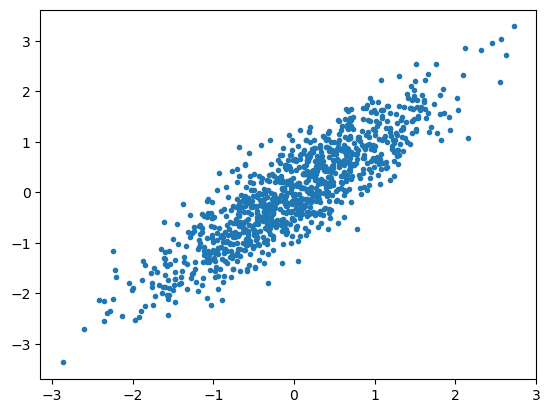

In [5]:
Y_pred=np.dot(X,np.vstack(B))
plt.plot(Y_pred,y,'.')
plt.show()



#### <span style="color:blue">REPONSE 3 </span> 

l'equivalent d'une regression lineaire multivariee a partir de l'information capturée par la PLS


### <span style="color:blue">Question 4 </span> 

En vous inspirant du cours, modifiez la fonction PLS1 de maniere a avoir une base de projecteurs parcimonieuse. Utilisez la pour trouver une base plus simple a expliquer que precedement.

### <span style="color:blue">Réponse 4 </span> 


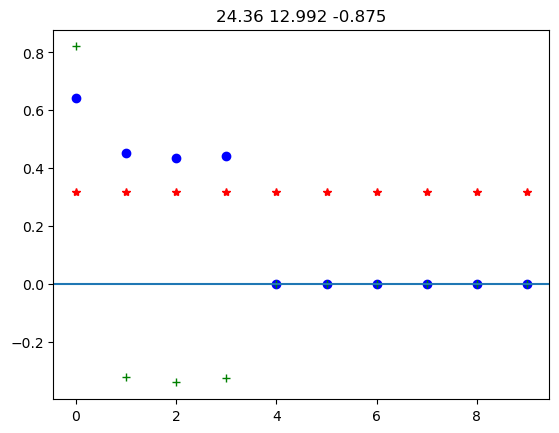

0.6036574072739186
0.09442053742954269
0.246935232473534


In [6]:

def sPLS1(X,y,l,lambda_val):
    """
    sparse PLS1 strategy - NIPALS algorithm

    Returns:
        - B: regression coefficients wrt the original predictors
        - W: orthonormal weights
        - P: matrix of X-loading
        - q: vector of y-loading
    """
    [n,p]=X.shape

    list_w_k=[]
    list_p_k=[]
    list_q_k=[]

    X_k=X.copy()
    v_k=np.dot(X_k.transpose(),y)
    s_v_k=v_k-lambda_val*np.sign(v_k)
    v_k=s_v_k*(np.sign(s_v_k*v_k)>0.)  #set to 0 if the sign of v_k changed
    if np.linalg.norm(v_k)<0.000001:
        v_k=np.ones(v_k.shape[0])    #to avoid numerial errors
    w_k=v_k/np.linalg.norm(v_k)   #covariance of each variable with y

    for k in range(l):
        #compute the projections and loadings
        tau_k=np.dot(X_k,w_k)   #weighted sum of the variables with weights that emphasize the variables of X that are the most correlated with y
        t_k=tau_k/np.linalg.norm(tau_k)
        p_k=np.dot(X_k.transpose(),t_k)   #projector: weighted sum of the observations with weights that emphasize the observations whose values participate most to the covariance with y in average
        q_k=np.dot(t_k.transpose(),y) #captured variability in y

        #save the elements for the matrices
        list_w_k.append(w_k)
        list_p_k.append(p_k)
        list_q_k.append(q_k)

        #prepare the next iteration
        if k<l-1:
            X_k=X_k-np.dot(t_k.reshape(-1,1),p_k.reshape(1,-1))  #enleve l'information capturee par la projection de X_k sur t_k
            v_k=np.dot(X_k.transpose(),y)    #covariance de chaque variable (apres avoir enleve la projection des donnees sur les precedents t_k) avec y
            s_v_k=v_k-lambda_val*np.sign(v_k)
            v_k=s_v_k*(np.sign(s_v_k*v_k)>0.)  #set to 0 if the sign of v_k changed
            if np.linalg.norm(v_k)<0.000001:
                v_k=np.ones(v_k.shape[0])    #to avoid numerial errors
            w_k=v_k/np.linalg.norm(v_k)

    #create the martices
    W=np.zeros([p,l])
    P=np.zeros([p,l])
    q=np.zeros(l)
    for i in range(l):
        W[:,i]=list_w_k[i]
        P[:,i]=list_p_k[i]
        q[i]=list_q_k[i]

    tmp=np.linalg.inv(np.dot(P.transpose(),W))
    B=np.dot(np.dot(W,tmp),q)

    return [B,W,P,q]




[B,W,P,q]=sPLS1(X,y,3,50.)


plt.plot(W[:,0],'bo')
plt.plot(W[:,1],'g+')
plt.plot(W[:,2],'r*')
plt.axline((0.,0.),(9.,0.))
plt.title(str(np.round(q[0],3))+' '+str(np.round(q[1],3))+' '+str(np.round(q[2],3)))
plt.show()


T_sparse=np.dot(X,W)
X_reco_sparse=np.dot(T_sparse,W.transpose())

print(np.abs(X[:,0:4]).std())
print(np.abs(X[:,0:4]-X_reco[:,0:4]).std())
print(np.abs(X[:,0:4]-X_reco_sparse[:,0:4]).std())




On a légèrement perdu dans l'approximation des données, mais la base est beaucoup plus simple à interpreter


REMARQUE : Pour aller plus loin, vous pouvez lire l'article 
[Indahl U.G.: "The geometry of PLS1 explained properly: 10 key notes on mathematical properties of and some alternative algorithmic approaches to PLS1 modelling", J. Chemometrics, 2013]
